# Exploring parameters

#### density plots, post predictive checks etc.

In [37]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions as sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
print(torch.__version__)

1.11.0


In [49]:
## defining neuronal network model

num_params = 17

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [50]:
window_len = 30

if num_params == 6:
    
    prior_min_fix = [0.0, 11.3, 0.0, 43.8, 0.0, 89.491]
    prior_max_fix = [0.160, 35.9, 0.821, 79.0, 8.104, 162.110]

    prior_min = [0.0, 11.3, 0.0, 43.8, 0.0, 89.491]
    prior_max = [0.160, 35.9, 0.821, 79.0, 8.104, 162.110]
    #true_params = torch.tensor([[26.61, 63.53,  137.12]])
    true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])

    

if num_params == 25:
    prior_min = [0, 0, 0, 0, 0, 0, 0, 0, 13.3,    # prox1 weights
                 0, 0, 0, 0, 0, 0, 51.980,            # distal weights
                 0, 0, 0, 0, 0, 0, 0, 0, 112.13]       # prox2 weights


    # ampa, nmda [0.927, 0.160, 2.093, 0.0519,        1.0, 1.0, 1.0, 1.0, 35.9,
    #           0.0394, 0.000042, 0.039372,           0.854, 0.117,  0.480, 75.08,
    #            0.000018, 8.633, 0.05375, 4.104,     1.0, 1.0, 1.0, 1.0, 162.110]

    prior_max = [0.927, 1.0, 0.160, 1.0,  2.093, 1.0, 0.0519, 1.0, 35.9,
                 0.0394, 0.117, 0.000042, 0.025902, 0.854, 0.480, 75.08,
                 0.000018, 1.0, 8.633, 1.0, 0.05375, 1.0, 4.104,  1.0, 162.110]

    true_params = torch.tensor([[0.277, 0.3739, 0.0399, 0.0, 0.6244, 0.3739, 0.034, 0.0, 18.977,
                                 0.011467, 0.06337, 0.000012, 0.013407, 0.466095, 0.0767, 63.08,
                                 0.000005, 0.116706, 4.6729, 0.016733, 0.011468, 0.061556, 2.33, 0.0679, 120.86]])
    
if num_params == 17:
    
    prior_min = [0, 0, 0, 0, 0, 13.3,  0, 0, 0, 0, 0, 51.980, 0, 0, 0, 0, 112.13]
    prior_max = [0.927, 0.160, 2.093, 1.0, 1.0, 35.9, 0.000042, 0.039372, 0.025902,  0.480, 0.117, 75.08, 8.633, 4.104, 1.0, 1.0, 162.110]

    true_params = torch.tensor([[0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 4.6729, 2.33, 0.016733, 0.0679, 120.86]])

if num_params == 20:

    prior_min = [0, 0, 0, 0, 0, 13.3, 1.276,  0, 0, 0, 0, 0, 51.980, 3.011, 0, 0, 0, 0, 112.13, 5.29]
    prior_max = [0.927, 0.160, 2.093, 1.0, 1.0, 35.9, 3.828, 0.000042, 0.039372, 0.025902,  0.480, 0.117, 75.08, 9.034, 8.633, 4.104, 1.0, 1.0, 162.110, 15.87]

    true_params = torch.tensor([[0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 2.55, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 6.02, 4.6729, 2.33, 0.016733, 0.0679, 120.86, 10.57]])



prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'


In [41]:

#assert (prior.event_shape==torch.Size([25]))
from utils import inference

In [45]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster/')



#print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster')

## loading simulations from previously saved computations
#file = 'ERP_sequential_3params/step3'
#file = 'ERP_save_sim_nsf_num_params3'
#file = 'eval_features'
#file = '10000_multi_round_num_params_25newparams'

#file = 'multi_round'
#file = '10000_sims_17_fake_obs_maf_ratio_validate'
#file='multi_round_10000_17params_nsf_fake_1804'
#file = '10000sims_17params_20_04_nsf_fake_lower_std'
#file = 'multi_round_10000_17params_nsf_fake_2104_001_std'

file = '10000sims_17params_11_04_nsf_fake_ratio'
file = '10000sims_17params_05_04_nsf_fake'

file = '10000sims_17params_30_04_nsf_fake'



#file = '10000sims_20params_26_04_nsf_No'
#file = '10000sims_20params_26_04_nsf_fake'

print(os.getcwd())

os.chdir('results')


print(os.getcwd())
  

#thetas = torch.load('{}/thetas.pt'.format(file))

posterior1 = torch.load('{}/posterior1.pt'.format(file))
posterior2 = torch.load('{}/posterior2.pt'.format(file))
posterior = torch.load('{}/posterior.pt'.format(file))

posterior_combined = sbi_modulated_functions.Combine_List([posterior1, posterior2, posterior], steps =[0, 6, 12, 17])

#neural_dens = torch.load('{}/neural_dens.pt'.format(file))
#x_without = torch.load('{}/obs_without.pt'.format(file))

#x = calculate_summary_stats_temporal(x_without)


#true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])
#true_params = torch.tensor([[  18.9700, 63.5300, 137.1200]])
#true_params = torch.load('results/{}/true_params.pt'.format(file))
#true_params = torch.tensor([[0.277, 0.0399, 0.3739, 0.034, 18.977, 0.0115, 0.000012, 0.466, 0.06337, 0.0134, 0.0766, 63.08, 0.000005, 4.6729, 0.0115, 0.3308, 120.86]])

#posteriors_round =  torch.load('{}/posteriors_each_round.pt'.format(file))
obs_real = torch.load('{}/obs_real.pt'.format(file))


/home/ubuntu
/home/ubuntu
/home/ubuntu/results


In [20]:
thetas = torch.load('{}/step1/thetas.pt'.format(file))


x_without = torch.load('{}/step1/obs_without.pt'.format(file))

In [21]:
## inference of first parameter set only after step1


prior1 = utils.torchutils.BoxUniform(low=prior_min[0:6], high=prior_max[0:6])

inf = SNPE(prior1, density_estimator=density_estimator)

x_N100 = calculate_summary_stats_temporal(x_without)

print('x:N100 shape', x_N100.shape)

inf = inf.append_simulations(thetas, x_N100)
neural_dens = inf.train()

posterior = inf.build_posterior(neural_dens)




batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch shape torch.Size([2801])
batch sh

Neural network successfully converged after 59 epochs.


In [22]:
obs_stat = calculate_summary_stats_temporal(obs_real)

posterior.set_default_x(obs_stat[:,:x_N100.shape[1]])

single observation
x shape torch.Size([1, 8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])


DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=BoxUniform(Uniform(low: torch.Size([6]), high: torch.Size([6])), 1),
               x_shape=torch.Size([1, 10]))
               

In [ ]:
obs_stat.shape

In [52]:
#obs_real_stat2 = calculate_summary_stats_temporal(obs_real[0])

samples = posterior.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [33]:
num_params = 17
parameter_names = ["prox1_ampa_l2_bas","prox1_ampa_l2_pyr","prox1_ampa_l5_bas","prox1_nmda_l5_bas", "prox1_nmda_l5_pyr",
 "t_prox1",
 "dist_ampa_l2_pyr","dist_ampa_l2_bas","dist_nmda_l2_pyr",
 "dist_nmda_l5_pyr","dist_nmda_l2_bas",
 "t_dist", 
 "prox2_ampa_l2_pyr","prox2_ampa_l5_pyr","prox2_nmda_l2_pyr","prox2_nmda_l5_pyr",
 "t_prox2"]


if num_params==20:
    parameter_names = ["prox1_ampa_l2_bas","prox1_ampa_l2_pyr","prox1_ampa_l5_bas","prox1_nmda_l5_bas", "prox1_nmda_l5_pyr",
 "t_prox1",'std_prox1',
 "dist_ampa_l2_pyr","dist_ampa_l2_bas","dist_nmda_l2_pyr",
 "dist_nmda_l5_pyr","dist_nmda_l2_bas",
 "t_dist", 'std_dist',
 "prox2_ampa_l2_pyr","prox2_ampa_l5_pyr","prox2_nmda_l2_pyr","prox2_nmda_l5_pyr",
 "t_prox2", 'std_prox2']

if num_params ==6:
    parameter_names = ["prox_1_ampa_l2_pyr",
     "t_evprox_1",
     "dist_nmda_l2_pyr",
     "t_evdist_1", 
     "prox_2_ampa_l5_pyr",
     "t_evprox_2"]

In [53]:
##better limits:

list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.3

print(diff)

list_min = list(list_min-diff)
#list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([-2.2111e-01, -9.3758e-02, -6.2460e-01, -5.3187e-01, -2.9510e-01,
         1.0198e+01, -3.5442e-06, -7.3538e-03, -9.7858e-03, -5.9549e-02,
        -5.1514e-02,  4.5425e+01, -2.6973e+00, -4.5906e-01, -3.7591e-01,
        -8.2652e-02,  1.1071e+02])
tensor([9.7311e-01, 1.7600e-01, 3.2760e+00, 1.0640e+00, 4.4352e-01, 3.3594e+01,
        5.8892e-05, 4.9039e-02, 3.4835e-02, 5.6657e-01, 1.6393e-01, 7.3969e+01,
        1.1828e+01, 4.1784e+00, 1.2825e+00, 4.8974e-01, 1.7721e+02])
tensor([3.5827e-01, 8.0928e-02, 1.1702e+00, 4.7875e-01, 2.2158e-01, 7.0189e+00,
        1.8731e-05, 1.6918e-02, 1.3386e-02, 1.8783e-01, 6.4634e-02, 8.5631e+00,
        4.3576e+00, 1.3912e+00, 4.9753e-01, 1.7172e-01, 1.9950e+01])


In [27]:
#limits[5][0] = 17

In [28]:
#limits = [list(tup ) for tup in zip(prior_min, prior_max)]
true_params_supra = torch.tensor([0.08831, 0.01525,  0.19934, 0, 0, 26.61, 0, 0, 0, 0, 0, 63.53,
                                 1.43884, 0.684013, 0, 0, 137.12])

<Figure size 432x288 with 0 Axes>

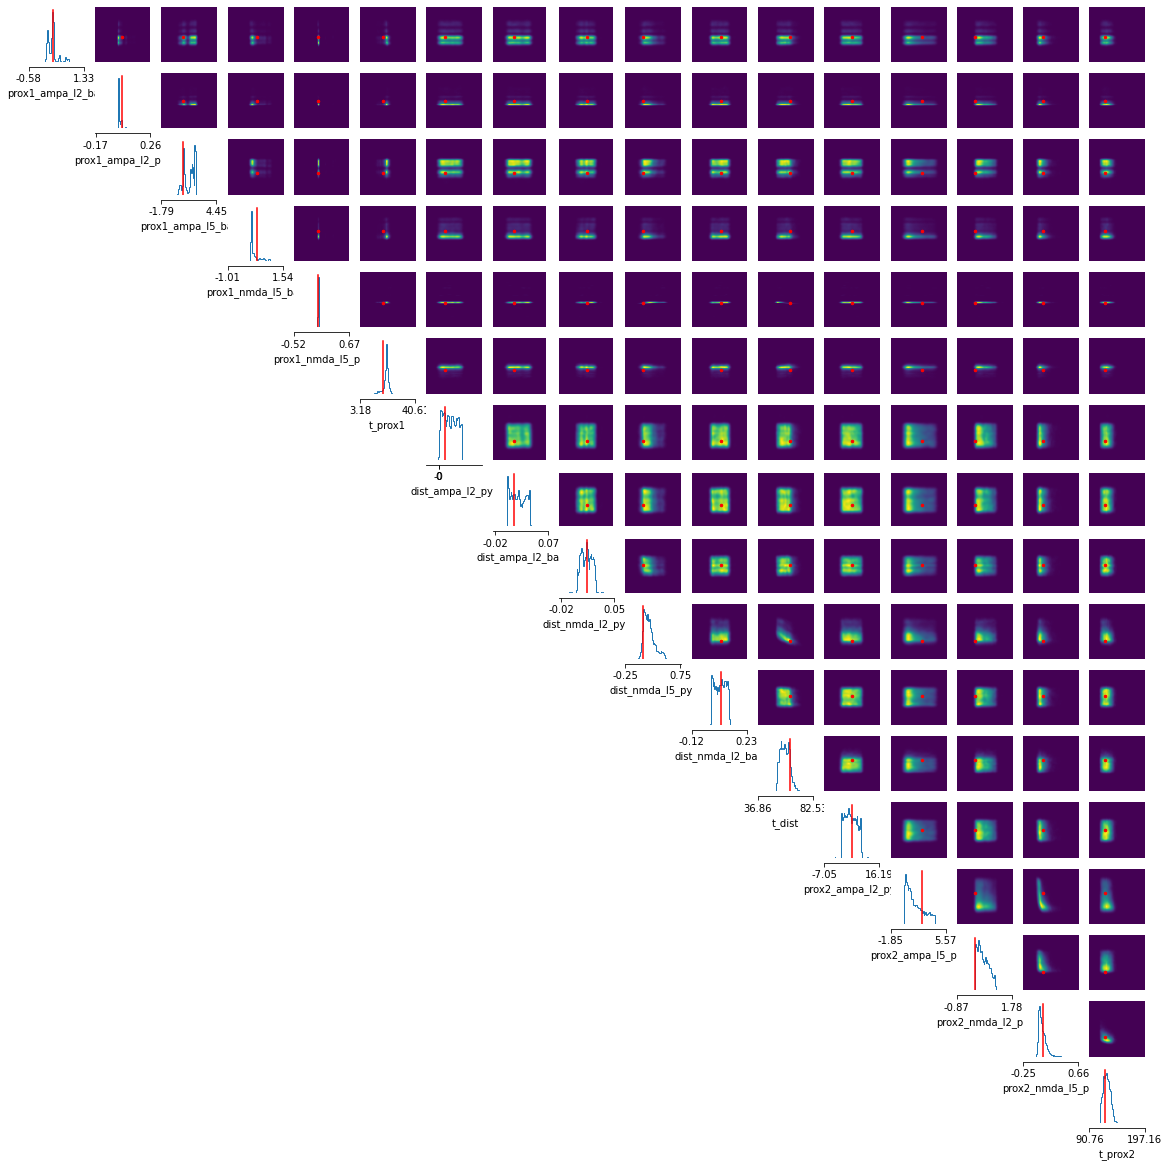

In [55]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]


plt.set_cmap('viridis')

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    upper = 'kde',
    lower='kde',
    #subset=[5, 11, 16],
    ticks=np.round(limits,2),
    figsize=(20, 20),
    points=true_params,
    points_offdiag={"markersize": 5},
    points_colors="r",
    labels=parameter_names,
)



#for i in range(5):
#    axes[i][i].xaxis.label.set_color('magenta')
#for i in range(5, 12):
#    axes[i][i].xaxis.label.set_color('navy')
#for i in range(12, 17):
#    axes[i][i].xaxis.label.set_color('deeppink')

In [10]:

file = 'multi_round'



#thetas = torch.load('{}/thetas.pt'.format(file))

posterior2 = torch.load('{}/posterior.pt'.format(file))

In [11]:
sample2 = posterior2.sample((1000,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.001


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 998 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0001818181818181818


KeyboardInterrupt: 

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/analysis/plot.py:420: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/analysis/plot.py:420: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/analysis/plot.py:420: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


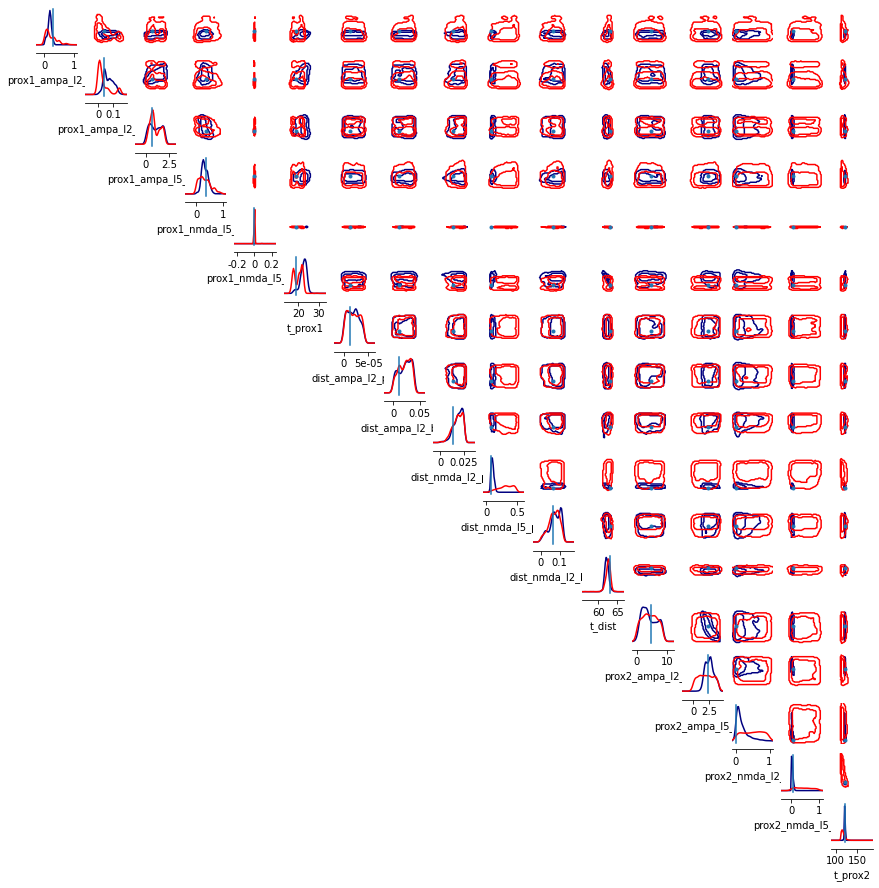

In [35]:
_ = analysis.pairplot(
    samples = [sample2, samples],
    points = true_params,
    limits = limits,
    #subset: List[int] = None,
    upper = "contour",
    diag = "kde",
    figsize = (15, 15),
    labels= parameter_names,

    #ticks: Union[List, torch.Tensor] = [],
    #points_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"],
    kde_offdiag = {
            "alpha": [0.8, 0.2],
            #"edgecolor": "none",
            #"rasterized": False,
            #'s': mpl.rcParams['lines.markersize'] ** 0.5,
            "bw_method": "scott",
            "bins": 50,
            #'cmap': 'viridis'
        },
    hist_offdiag_alpha = 0.02,
    points_offdiag={"markersize": 6},
    #samples_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"],
    #fig=None,
    #axes=None,
    #**kwargs,
    scatter_offdiag = {
            "alpha": 0.2,
            "edgecolor": "none",
            "rasterized": True,
            's': mpl.rcParams['lines.markersize'] ** 0.5
        },
    contour_offdiag={"levels":  [0.68, 0.95]},
    samples_colors =  ['#000080', '#FF0000'],
)

In [12]:
import pandas as pd

os.chdir('..')
trace = pd.read_csv('data/ERPYes3Trials/dpl.txt', sep='\t', header=None, dtype= np.float32)

print(trace)
obs_real = torch.tensor(trace.values, dtype = torch.float32)

trace2 = pd.read_csv('data/default/dpl.txt', sep='\t', header=None, dtype= np.float32)

print(trace)
obs_real2 = torch.tensor(trace2.values, dtype = torch.float32)


trace3 = pd.read_csv('data/ERPNo100Trials/dpl_1.txt', sep='\t', header=None, dtype= np.float32)

print(trace)
obs_real3 = torch.tensor(trace3.values, dtype = torch.float32)


               0          1         2          3
0       0.000000  -0.597602 -0.000357  -0.597244
1       0.025000  -0.598407 -0.000356  -0.598051
2       0.050000  -0.599206 -0.000355  -0.598852
3       0.075000  -0.600000 -0.000354  -0.599647
4       0.100000  -0.600788 -0.000352  -0.600436
...          ...        ...       ...        ...
6796  169.899994  24.551149  8.279498  16.271650
6797  169.925003  24.471813  8.248908  16.222906
6798  169.949997  24.392578  8.218372  16.174206
6799  169.975006  24.313431  8.187889  16.125544
6800  170.000000  24.234365  8.157454  16.076912

[6801 rows x 4 columns]
               0          1         2          3
0       0.000000  -0.597602 -0.000357  -0.597244
1       0.025000  -0.598407 -0.000356  -0.598051
2       0.050000  -0.599206 -0.000355  -0.598852
3       0.075000  -0.600000 -0.000354  -0.599647
4       0.100000  -0.600788 -0.000352  -0.600436
...          ...        ...       ...        ...
6796  169.899994  24.551149  8.279498  16.27

In [14]:
os.getcwd()

'/home/ubuntu'

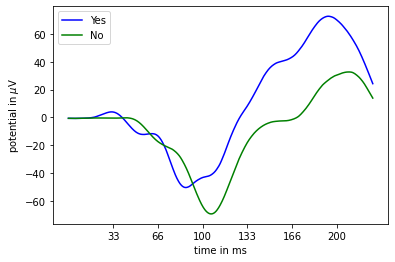

In [13]:
plt.plot(obs_real[:,1], c='blue', label='Yes')
#plt.plot(obs_real2[:,1], c='orange', label='default')

#plt.plot(obs_real[:,2], c='blue')
#plt.plot(obs_real2[:,:], c='orange')

plt.plot(obs_real3[:,1], c='green', label='No')
#plt.plot(obs_real3[:,2], c='red')


plt.xticks([1000, 2000, 3000, 4000, 5000, 6000],[33, 66, 100, 133, 166, 200])
plt.xlabel('time in ms')

plt.ylabel('potential in $\mu$V')
plt.legend()

In [216]:
condition = posterior.sample((1,))
condition2 = posterior.sample((1,))


condition.shape

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 17])

## Conditional density plot

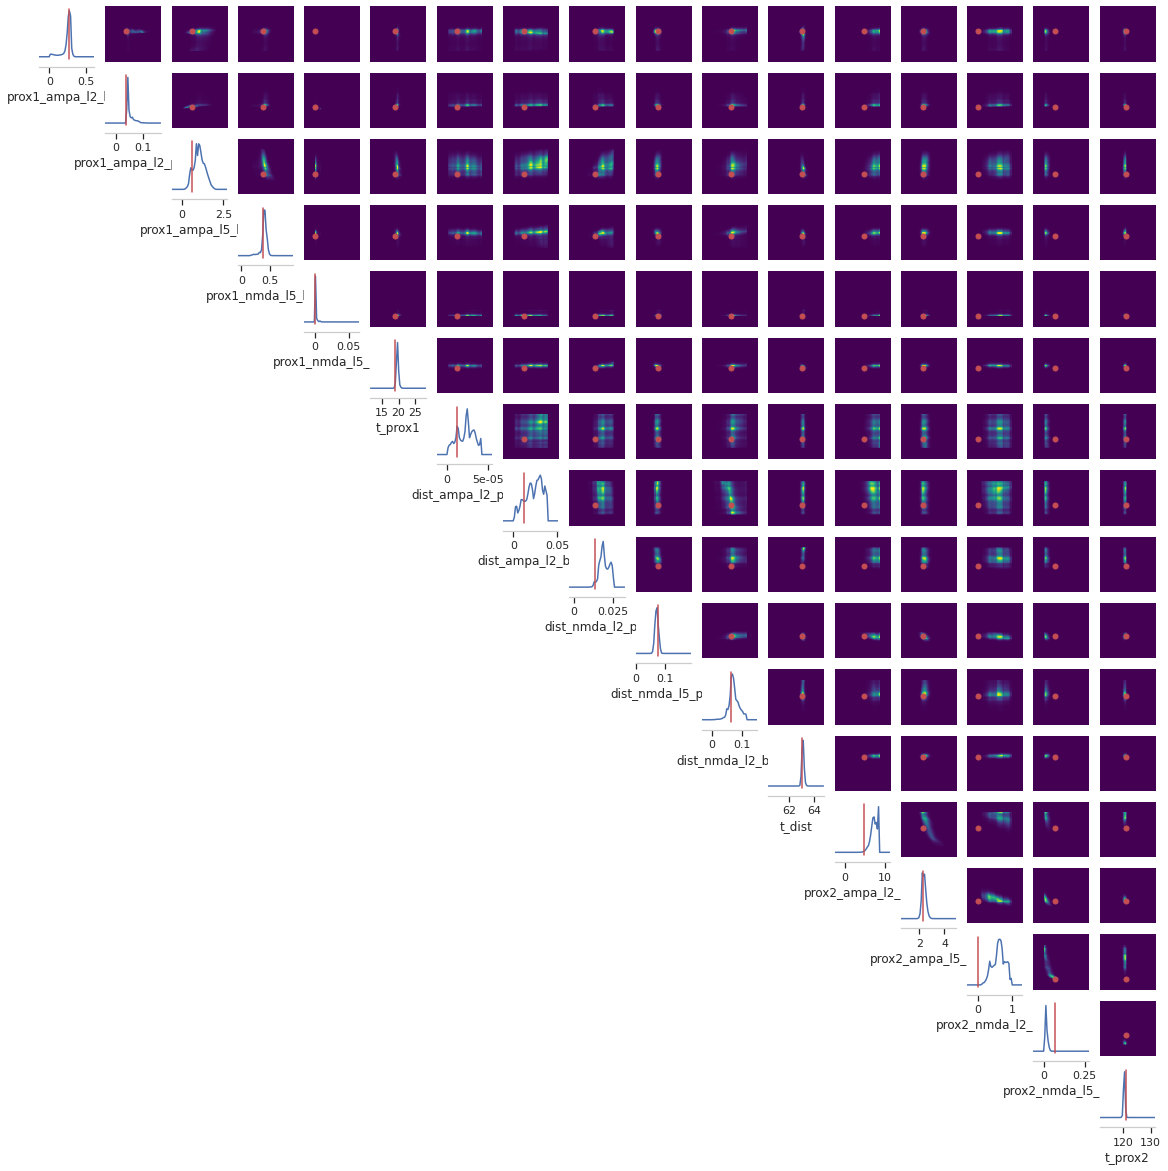

In [220]:
fig, ax = analysis.conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=limits,
    figsize=(20, 20),
    points=true_params,
    upper = 'kde',
    lower='kde',
    points_offdiag={"markersize": 10},
    points_colors="r",
    labels=parameter_names,
    #subset = [1, 3, 5]
    #color_map = ['Blues', 'Reds'],
    #alpha1 = 0.8,
    #alpha2 = 0.4

)




In [15]:
obs_real_stat = posterior.default_x
samples = posterior.sample((100,), x=obs_real_stat)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

acceptance rate:  1.0


In [30]:
samples

tensor([[ 2.4126e-01, -4.4336e-02,  1.2559e-01,  5.5271e-01, -1.5584e-03,
          1.9723e+01, -4.6453e-06,  4.2340e-03,  2.8076e-02,  5.7611e-02,
         -3.9018e-03,  6.3142e+01,  4.4349e+00,  4.7321e+00,  7.8110e-01,
         -1.3360e-01,  1.2211e+02]])

In [35]:
samples
samples2 = samples.clone().detach()

samples2[:,1:4] = -samples2[:,1:4]

In [37]:
samples2

tensor([[ 2.4126e-01,  4.4336e-02, -1.2559e-01, -5.5271e-01, -1.5584e-03,
          1.9723e+01, -4.6453e-06,  4.2340e-03,  2.8076e-02,  5.7611e-02,
         -3.9018e-03,  6.3142e+01,  4.4349e+00,  4.7321e+00,  7.8110e-01,
         -1.3360e-01,  1.2211e+02]])

In [38]:
#s_x = inference.run_only_sim(samples, simulation_wrapper=sim_wrapper, num_workers=8)
s_x2 = inference.run_only_sim(samples2, simulation_wrapper=sim_wrapper, num_workers=8)

param size 17
early stop 200.0
param size  17
num_params 17
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
Loading custom mechanism files from /home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
obs [-0.59758303 -0.59837782 -0.59916343 ...  8.3196034

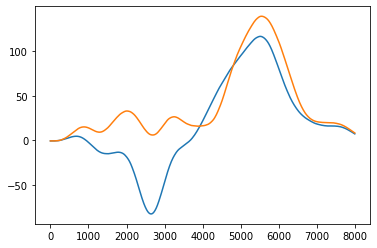

In [39]:
plt.plot(s_x[0])
plt.plot(s_x2[0])

In [17]:
### sample from prior now
num_samples = 100
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)
    

In [18]:
samples_prior[:][0].shape

torch.Size([17])

In [19]:
    
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers=8)

param size 17param sizeparam size 
param sizeearly stop 17  17param sizeparam size17
 
param sizeearly stopparam size 
  17early stop
200.0  17200.017
200.0early stop
param size 
early stop17
early stop   200.0early stop

param size  
early stop17200.0param size  200.0 param size 200.0

  
17param size param size   
 17
17param size 17
 

1717
200.0

param size  17
num_paramsnum_params  num_params17 
17
17num_params
 joblib will run over 1 jobsnum_params17
joblib will run over 1 jobs 17


joblib will run over 1 jobs
num_paramsjoblib will run over 1 jobs joblib will run over 1 jobs17
num_params
num_params  1717
[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.

joblib will run over 1 jobs

joblib will run over 1 jobsjoblib will run over 1 jobs

Loading custom mechanism files from /home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ubuntu/miniconda3/envs/sbi_

obs [-0.59760178 -0.59840714 -0.59920666 ... 41.59663149 41.45813874
 41.31974065]
param size 17
early stop 200.0
param size obs [-0.59760178 -0.59840714 -0.59920666 ... 32.33069308 32.22409517
 32.11751935] 17

param size 17
early stop 200.0
param size  17
num_params 17
joblib will run over 1 jobs
num_params 17[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:  1.7min

joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
obs [-0.59760178 -0.59840714 -0.59920666 ... 32.54150472 32.43592097
 32.33039532]
param size 17
early stop 200.0
param size  17
Building the NEURON model
num_params 17
joblib will run over 1 jobs
Building the NEURON model
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:  1.7min
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time:

Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 50.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 60.0 ms...
Simulation time: 80.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 70.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 70.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 80.0 ms...
Simulation time: 100.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 110.0 ms...
Simulation 

 20.47537337]
param size 17
early stop 200.0
param size  17
num_params 17
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  41 tasks      | elapsed:  9.8min
Simulation time: 150.0 ms...
Simulation time: 180.0 ms...
Simulation time: 140.0 ms...
Building the NEURON model
Simulation time: 190.0 ms...
Simulation time: 170.0 ms...
Simulation time: 170.0 ms...
Simulation time: 190.0 ms...
Simulation time: 190.0 ms...
Simulation time: 160.0 ms...
Simulation time: 150.0 ms...
obs [-0.59760178 -0.59840714 -0.59920666 ... 32.35434693 32.25865721
 32.16302707]
param size 17
early stop 200.0
param size  17
num_params 17
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  42 tasks      | elapsed:  9.9min
Simulation time: 180.0 ms...
Simulation time: 180.0 ms...
Building the NEURON model
obs [-0.59760178 -0.59840714 -0.59920666 ... 33.40740322 33.29673819
 33.18612579]
param size 17
early stop 200.0
param size  17
num_params 17
[Parallel(n_jobs=8)]: Done  43 tasks      | elapsed:  9.9min
j

 51.10256968]param size Simulation time: 0.03 ms...
param size
 17 
17
early stop 200.0
param size  17
obs [-0.59760178 -0.59840714 -0.59920666 ... 24.57558293 24.49693389
 24.41831656]
param size 17num_params 
early stop 17
200.0
joblib will run over 1 jobsparam size  17

num_params 17[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed: 11.7min
[Parallel(n_jobs=8)]: Done  53 tasks      | elapsed: 11.7min
[Parallel(n_jobs=8)]: Done  54 tasks      | elapsed: 11.7min

joblib will run over 1 jobs
num_params 17
joblib will run over 1 jobs
Simulation time: 160.0 ms...
Building the NEURON model
Building the NEURON model
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 170.0 ms...
Simulation time: 10.0 ms...
Simulation time: 170.0 ms...
Simulation time: 20.0 ms...
Simulation time: 10.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 180.0 ms...
Simulation time: 30.0 ms...
Simulation time: 180.0 ms...


Simulation time: 40.0 ms...
Simulation time: 10.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 100.0 ms...
Simulation time: 50.0 ms...
Simulation time: 70.0 ms...
Simulation time: 10.0 ms...
Simulation time: 50.0 ms...
Simulation time: 20.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 110.0 ms...
Simulation time: 60.0 ms...
Simulation time: 80.0 ms...
Simulation time: 20.0 ms...
Simulation time: 60.0 ms...
Simulation time: 30.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 120.0 ms...
Simulation time: 70.0 ms...
Simulation time: 90.0 ms...
Simulation time: 30.0 ms...
Simulation time: 70.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 130.0 ms...
Simulation time: 80.0 ms...
Simulation time: 100.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time

Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 120.0 ms...
Simulation time: 70.0 ms...
Simulation time: 100.0 ms...
Simulation time: 180.0 ms...
Simulation time: 70.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 130.0 ms...
Simulation time: 80.0 ms...
Simulation time: 110.0 ms...
Simulation time: 190.0 ms...
Simulation time: 80.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 90.0 ms...
Simulation time: 120.0 ms...
obs [ 0.15106769  0.1584406   0.16583506 ... 49.00699094 48.84775247
 48.68860314]
param sizeSimulation time: 90.0 ms...
 17
early stop 200.0
param size  17
num_params 17
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  81 tasks      | elapsed: 18.1min
Simulation time: 120.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Building the NEURON mo

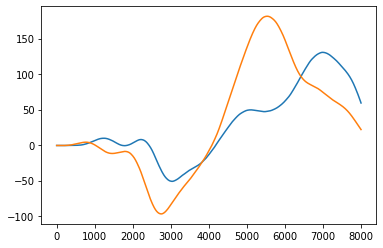

In [20]:
plt.plot(s_x_prior[0])
plt.plot(s_x[0])

In [21]:
s_x_torch = torch.stack(([s_x[i] for i in range(39)]))
s_x_prior_torch = torch.stack(([s_x_prior[i] for i in range(39)]))


mean = torch.mean(s_x_torch, 0)
std = torch.std(s_x_torch, 0)

mean_prior = torch.mean(s_x_prior_torch, 0)
std_prior = torch.std(s_x_prior_torch, 0)

lower = mean - 1.96 * std


upper = mean + 1.96 * std


lower_prior = mean_prior - 1.96 * std_prior


upper_prior = mean_prior + 1.96 * std_prior



In [25]:
obs_real


tensor([-0.1389, -0.9113,  1.8501,  ...,  9.9044, 11.0654, 11.1350],
       dtype=torch.float64)

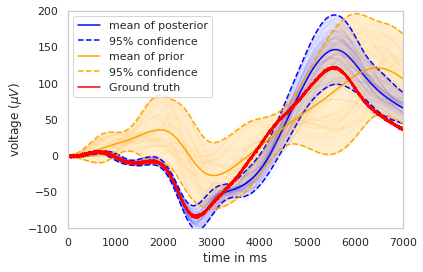

In [26]:
import seaborn as sns

sns.set() 

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style('ticks')

fig1, ax = plt.subplots(1, 1)
#ax.set_title("Comparing signal")

    
plt.plot(mean, color ='blue', label='mean of posterior')

for s in s_x[0:40]:
    plt.plot(s, alpha=0.05, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)

plt.plot(lower, color='blue', linestyle='dashed', label='95% confidence')
plt.plot(upper, color='blue', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower, y2=upper, color='blue', alpha=0.1)
plt.xlim(0, 7000)
plt.ylim(-100, 200)


plt.plot(mean_prior, color ='orange', label='mean of prior')


for x_w in s_x_prior[0:40]:
    plt.plot(x_w, alpha=0.05, color='orange')

plt.plot(lower_prior, color='orange', linestyle='dashed', label='95% confidence')
plt.plot(upper_prior, color='orange', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower_prior, y2=upper_prior, color='orange', alpha=0.2)
plt.xlim(0, 7000)

plt.xlabel('time in ms')
#plt.ylabel('voltage ()')

fig1.gca().set_ylabel(r'voltage ($\mu V$)')
    
plt.plot(obs_real, label='Ground truth', color='red')



plt.legend()

## Correlation matrices

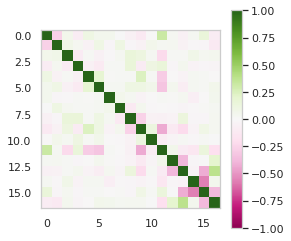

In [244]:
corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


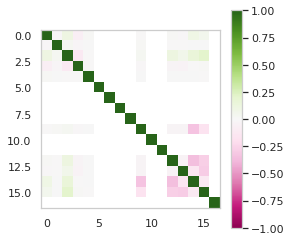

In [245]:
condition = posterior.sample((1,))

cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2., 2.]]*17),
)

fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

## Looking at correlations of parameters

In [ ]:
## parameter 3 and 4 should be highly correlated:

## Evaluation of features

In [8]:
import matplotlib.cm as cm
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch import Tensor
from typing import Tuple, List, Optional, Dict
from matplotlib.pyplot import Axes
from matplotlib.figure import Figure
from matplotlib.colors import LogNorm


In [83]:
t = obs_real_stat

t

tensor([[ 6.9800e+02,  2.6790e+03,  5.5510e+03,  5.0662e+00, -9.2767e+01,
          1.1571e+02,  3.0405e+00,  2.9002e+01,  1.1269e+02,  3.5632e+00,
          4.9754e+03,  6.3653e+00,  1.9096e+00, -1.1660e+01, -1.0371e+01,
         -1.5394e+01, -3.4815e+01, -6.5808e+01,  3.7142e+01]],
       dtype=torch.float64)

In [84]:
# t.shape

t1 = torch.cat((t[:,:1], t[:,1+1:]), axis = 1)
print(t1)
t1.shape

tensor([[ 6.9800e+02,  5.5510e+03,  5.0662e+00, -9.2767e+01,  1.1571e+02,
          3.0405e+00,  2.9002e+01,  1.1269e+02,  3.5632e+00,  4.9754e+03,
          6.3653e+00,  1.9096e+00, -1.1660e+01, -1.0371e+01, -1.5394e+01,
         -3.4815e+01, -6.5808e+01,  3.7142e+01]], dtype=torch.float64)


torch.Size([1, 18])

In [85]:
posterior.set_default_x(obs_real_stat)

In [86]:
thetas = posterior.sample((10000,))
thetas.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 17])

In [89]:

for i in range(19):
    x = calculate_summary_stats_temporal(x_without)
    #leaving one summary statistic out
    x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
    print(x_c.shape)
    print('t shape', t.shape)
    print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
    inf = SNPE(prior=prior, density_estimator = 'nsf')
    inf = inf.append_simulations(thetas, x_c)
    density_estimator = inf.train()
    posterior1 = inf.build_posterior(density_estimator)
    globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))


batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
torch.Size([19000, 18])
t shape torch.Size([1, 19])
torch.Size([0, 19])


AssertionError: Number of parameter sets (=10000 must match the number of simulation outputs (=19000)

In [13]:
sum_stats_names =                                [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_moment1',
                    'N100_moment1',
                    'P200_moment1',
                    'p50_moment2',
                    'N100_moment2',
                    'P200_moment2',
                    'mean1000',
                    'mean1500',
                    'mean1700',
                    'mean1900',
                    'mean2100',
                    'mean2300',
                    'mean4000',
                ]

sample_list = []
for i in range(len(sum_stats_names)):
    sample_list.append(globals()['samples_%s' % i] )

    
plt.figure(figsize = (25,20))
im = plot_varchanges(sample_list, samples, xticklabels=sum_stats_names, yticklabels= parameter_names, plot_label='', batchsize=0)
plt.show(im)

KeyError: 'samples_0'

In [90]:
sample_batch = []
batch_size = 5

for i in range(batch_size):

    sample_list = []
    
    for i in range(19):
        

        x = calculate_summary_stats_temporal(x_without)
        #leaving one summary statistic out
        x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
        print(x_c.shape)
        print('t shape', t.shape)
        print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
        inf = SNPE(prior=prior, density_estimator = 'nsf')
        inf = inf.append_simulations(thetas, x_c)
        density_estimator = inf.train()
        posterior1 = inf.build_posterior(density_estimator)
        globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))
        
        sample_list.append(globals()['samples_%s' % i] )
        
    sample_batch.append(sample_list)

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

torch.Size([19000, 18])
t shape torch.Size([1, 19])
torch.Size([0, 19])


AssertionError: Number of parameter sets (=10000 must match the number of simulation outputs (=19000)

In [119]:
sample_batch

[]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0, 0.5, 'voltage ($\\mu V$)')

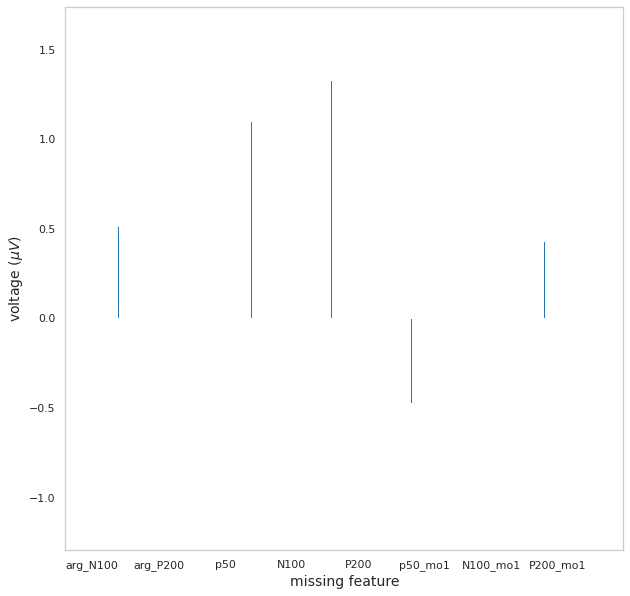

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True)


plot_KLs(sample_list,
        samples,
        idx=0,
        batchsize=0,
         kind='bar',
        agg_with='mean'
    )


axes.set_xlabel("missing feature", size=14)
axes.set_xticklabels(sum_stats_names)
ax.tick_params(axis="both", which="major", labelsize=12)
ylabel = ax.get_ylabel()
axes.set_ylabel(ylabel, size=14)


## Histograms

In [65]:
s_x_prior_stat = calculate_summary_stats_temporal(s_x_prior_torch)

s_x_stat = calculate_summary_stats_temporal(s_x_torch)

batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch shape torch.Size([8001])
batch sh

In [52]:
s_x_prior_stat.shape

torch.Size([100, 19])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


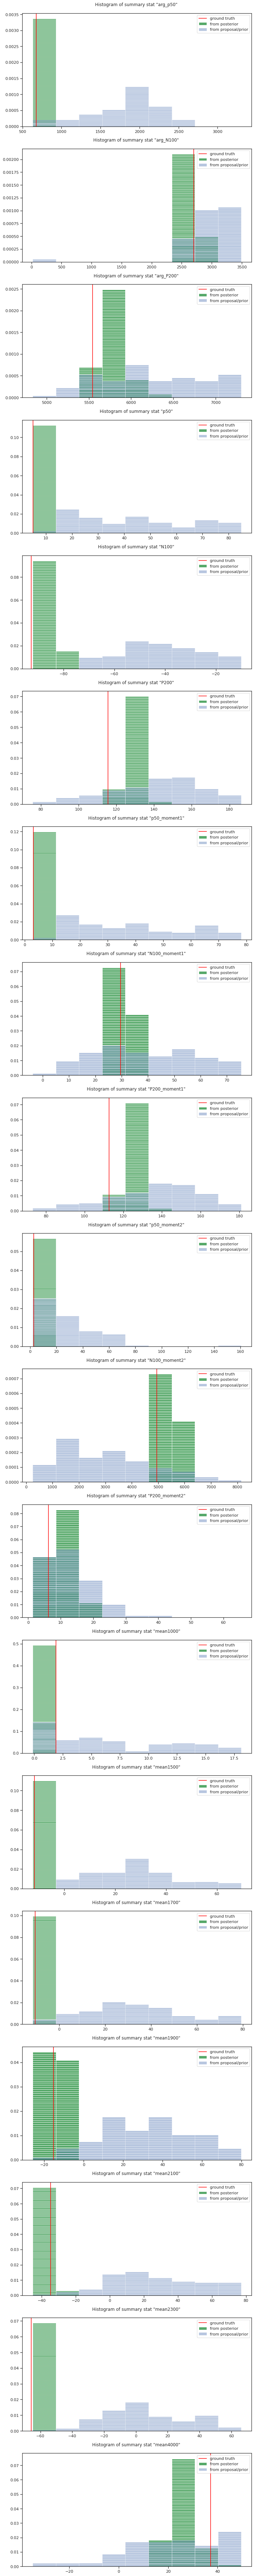

In [93]:
import matplotlib.gridspec as gridspec


import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_style("dark")
#sns.set_style("white")
sns.set_style("ticks")



fig = plt.figure(figsize=(10,100), tight_layout=True)

gs = gridspec.GridSpec(nrows=len(sum_stats_names), ncols=1)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(19):
    
    print(i)

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(s_x_prior_stat.shape[0]):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])

    sum_stat = globals()['sum_stats%s' % i]
    x_s = globals()['x%s' % i]

    ##define bins such that we get an equal number of bins at the end
    
    binsteps = np.abs(max([max(x_s), max(sum_stat)])-min([min(x_s), min(sum_stat)]))*0.1 
    
   
    binrange = np.arange(min([min(x_s), min(sum_stat)]), max([max(x_s), max(sum_stat)]), binsteps)
  

   
    
    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, bins=binrange, facecolor='g', alpha=0.99, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, bins=binrange, facecolor='b', alpha=0.4, histtype='barstacked', label='from proposal/prior')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stat[0][i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')

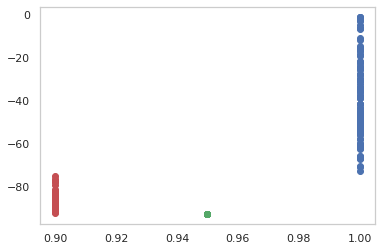

In [89]:
for i in range(100):

    plt.scatter(1,s_x_prior_stat[i][4], color='b')
    plt.scatter(0.9,s_x_stat[i][4], color='r')
    plt.scatter(0.95, obs_real_stat[0][4], color='g')

In [71]:
obs_real_stat[0][0]

tensor(677.)

In [8]:
from sbi.analysis.sbc import check_sbc, run_sbc, get_nltp
from sbi.analysis.plot import sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

In [66]:
thetas = torch.stack(([samples_prior[i] for i in range(len(samples_prior))]))
xs = s_x_prior_stat

In [73]:
posterior.sample((1000,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[4.9720e-02, 1.9231e+01, 1.6711e-02, 6.1002e+01, 7.4212e-02, 1.1468e+02],
        [3.2012e-02, 1.9392e+01, 1.7936e-02, 6.2570e+01, 3.4590e-02, 1.1599e+02],
        [5.3737e-02, 1.9460e+01, 2.8572e-03, 6.1723e+01, 2.1022e-01, 1.1322e+02],
        ...,
        [6.5962e-02, 2.0285e+01, 7.5865e-03, 6.1476e+01, 5.8498e-02, 1.1233e+02],
        [5.3234e-02, 1.9263e+01, 8.2176e-03, 6.1631e+01, 2.7745e-02, 1.1345e+02],
        [6.3074e-02, 1.8466e+01, 1.3858e-02, 6.1144e+01, 6.8865e-02, 1.1506e+02]])

In [89]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1000
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_posterior_samples=num_posterior_samples)

check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)


print(f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}")


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/analysis/sbc.py:50: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  results. We recommend using 300."""


Running 100 sbc samples.:   0%|          | 0/100 [00:00<?, ?it/s]

assertion error


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [5.4196433e-26 6.1653069e-40 0.0000000e+00 1.2131434e-23 0.0000000e+00
 5.5036876e-17]


In [87]:
print(f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}")
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")


c2st accuracies 
check_stats['c2st_ranks'] = [0.8   0.905 0.95  0.91  0.875 0.79 ]
- c2st accuracies check_stats['c2st_dap'] = [0.82  0.935 0.96  0.895 0.72  0.625]


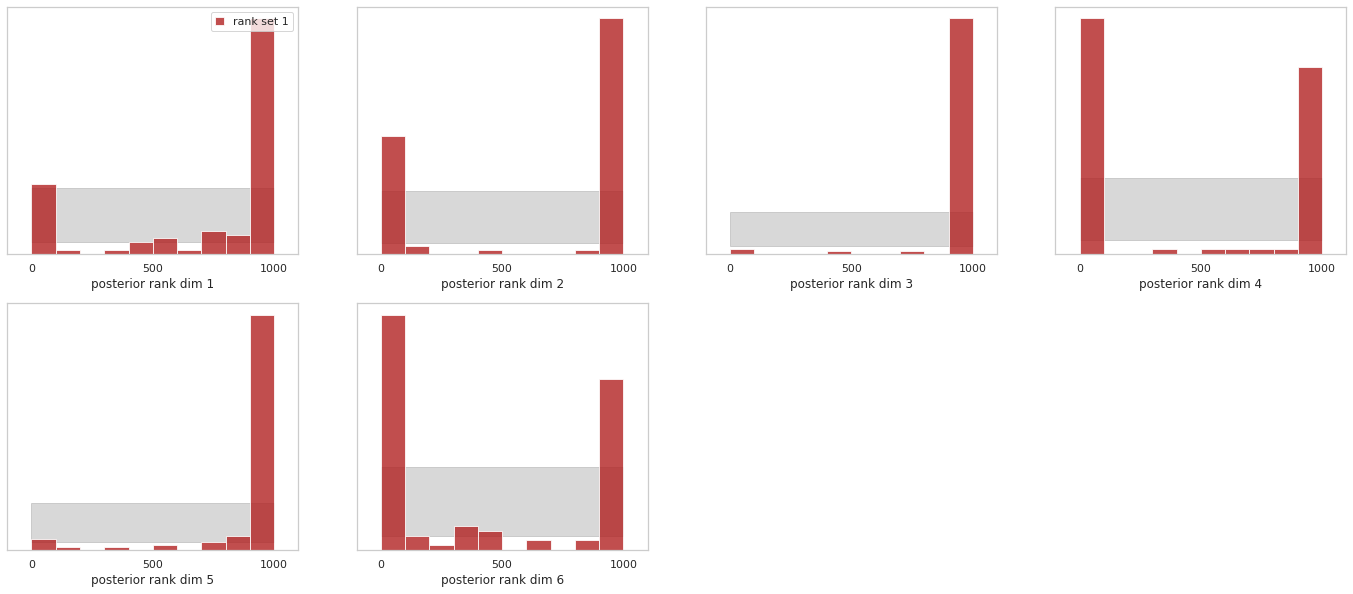

In [88]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks=ranks,
                      num_posterior_samples=num_posterior_samples,
                      plot_type="hist",
                      num_bins=10 # by passing None we use a heuristic for the number of bins.
                      )

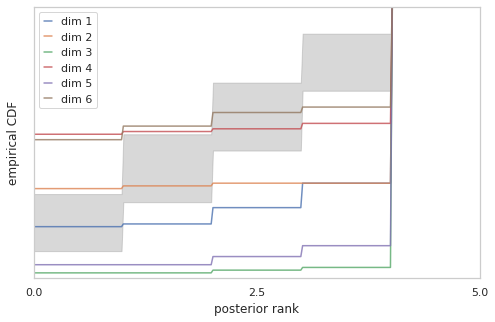

In [85]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "cdf")